In [1]:
# Visualizations will be shown in the notebook.
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2

In [2]:
path = 'data'
img_path = path + '/IMG'
models_path = "./models"

In [3]:
def load_csv(file_path, col_names, remove_header=False):
    csv = pd.read_csv(file_path, header=None, names=col_names)
    if remove_header:
        csv = csv[1:]
    
    return csv

In [4]:
col_header_names = ["Center", "Left", "Right", "Steering Angle", "Throttle", "Brake","Speed"]

In [5]:
# load the dataset
csv = load_csv(path + "/driving_log.csv", col_header_names, remove_header=True)
csv["Steering Angle"] = csv["Steering Angle"].astype(float) 
print("Dataset has {0} rows".format(len(csv)))

Dataset has 6483 rows


In [6]:
def get_steering_angles(data, st_column, st_calibrations, filtering_f=None):
    """
    Returns the steering angles for images referenced by the dataframe
    The caller must pass the name of the colum containing the steering angle 
    along with the appropriate steering angle corrections to apply
    """
    cols = len(st_calibrations)
    print("CALIBRATIONS={0}, ROWS={1}".format(cols, data.shape[0]))
    angles = np.zeros(data.shape[0] * cols, dtype=np.float32)
    
    i = 0
    for indx, row in data.iterrows():        
        st_angle = row[st_column]
        for (j,st_calib) in enumerate(st_calibrations):  
            angles[i * cols + j] = st_angle + st_calib
        i += 1
    
    # Let's not forget to ALWAYS clip our angles within the [-1,1] range
    return np.clip(angles, -1, 1)

In [7]:
st_angle_names = ["Center", "Left", "Right"]
st_angle_calibrations = [0, 0.25, -0.25]

In [8]:
st_angles_without_calibrations = get_steering_angles(csv, "Steering Angle", [0])

CALIBRATIONS=1, ROWS=6483


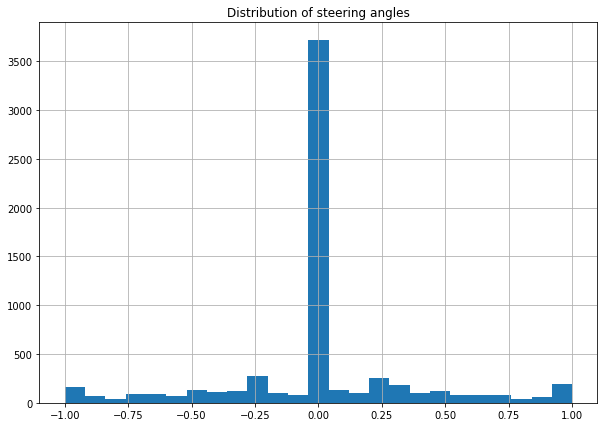

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.grid(True)
ax.set(title="Distribution of steering angles")
count, bins, _ = ax.hist(st_angles_without_calibrations, bins=25, histtype='bar')

In [10]:
len(csv)

6483

In [11]:
def read_img(img_full_path, img_dir="/IMG"):
    prefix_path = path + img_dir
    
    img_path = "{0}/{1}".format(prefix_path, img_full_path.split("\\")[-1])    
    img = cv2.imread(img_path)
    
    # OpenCV reads images in BGR format, we are simply converting and returning the image in RGB format
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [12]:
def fliph_image(img):
    """
    Returns a horizontally flipped image
    """
    return cv2.flip(img, 1)

In [13]:
def blur_image(img, f_size=5):
    """
    Applies Gaussir Blur to smoothen the image.
    This in effect performs anti-aliasing on the provided image
    """
    img = cv2.GaussianBlur(img,(f_size, f_size),0)
    img = np.clip(img, 0, 255)

    return img.astype(np.uint8)

In [14]:
# Read more about it here: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def translate_image(img, st_angle, low_x_range, high_x_range, low_y_range, high_y_range, delta_st_angle_per_px):
    """
    Shifts the image right, left, up or down. 
    When performing a lateral shift, a delta proportional to the pixel shifts is added to the current steering angle 
    """
    rows, cols = (img.shape[0], img.shape[1])
    translation_x = np.random.randint(low_x_range, high_x_range) 
    translation_y = np.random.randint(low_y_range, high_y_range) 
    
    st_angle += translation_x * delta_st_angle_per_px

    translation_matrix = np.float32([[1, 0, translation_x],[0, 1, translation_y]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))
    
    return img, st_angle

In [15]:
def change_image_lightness(img, low, high):
    """
    Applies an offset in [low, high] interval to change the 'L' component of the supplied image in HSL format
    The returned image in converted back to RGB
    """
    # Convert to HSL (HLS in OpenCV!!)
    hls = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HLS)
    hls = hls.astype(int)    
    
    # Add an offset to light component 
    offset = np.random.randint(low, high=high)
    # Since the format is HLS and NOT HSL, it is the second component (index 1) that is modified
    #hls[:,:,1] += offset
    hls[:,:,1] = offset

    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hls, 0, 255)
    
    # Convert back to uint
    hls = hls.astype(np.uint8)
    
    # Make sure we return image in RGB format
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

In [16]:
def change_image_brightness(img, low, high):
    """
    Applies an offset in [low, high] interval to change the 'V' component of the supplied image in HSV format
    The returned image in converted back to RGB
    """

    # Convert to HSV
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv = hsv.astype(int)    
    
    # Adding the offset to the v component
    offset = np.random.randint(low, high=high)
    hsv[:,:,2] += offset
    
    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hsv, 0, 255)
    
    # Convert back to uint
    hsv = hsv.astype(np.uint8)
    
    # Make sure we return image in RGB format
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [17]:
def add_random_shadow(img, w_low=0.6, w_high=0.85):
    """
    Overlays supplied image with a random shadow poligon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)

    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    #masked_image = cv2.bitwise_and(img, mask)
    
    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

In [18]:
def shift_horizon(img, h_s=0.2):
    img = img.astype(np.float32)
    
    # randomly shift horizon
    height = img.shape[0]
    width = img.shape[1]
    horizon = h_s * height / 3
    v_shift = np.random.randint(-height/8,height/8)
    pts1 = np.float32([[0, horizon],[width, horizon], [0, height], [width, height]])
    pts2 = np.float32([[0, horizon + v_shift],[width, horizon + v_shift], [0, height], [width, height]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, M,(width, height), borderMode=cv2.BORDER_REPLICATE)
    
    return img.astype(np.uint8)

In [19]:
def change_gamma(img, gamma=0.5):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    img = img.astype(np.float32) 
    img /= 255.0
    
    #img[:,:100,:] = img[:,:100,:] ** invGamma
    #img *= 255
    #img = img.astype(np.uint8)
    img = cv2.bitwise_and(img * 255, img * 255, mask=img[:,:100,:] ** invGamma)
    return img
    
    #table = np.array([((i / 255.0) ** invGamma) * 255
    #for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(img, table)

In [20]:
def change_image_brightness_rgb(img, s_low=0.2, s_high=0.75):
    """
    Changes the image brightness by multiplying all RGB values by the same scalacar in [s_low, s_high).
    Returns the brightness adjusted image in RGB format.
    """
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

In [21]:
def augment_image(img, st_angle, p=1.0):
    """
    Augment a given image, by applying a series of transformations, with a probability p.
    The steering angle may also be modified.
    Returns the tuple (augmented_image, new_steering_angle)
    """
    aug_img = img
    
    #if np.random.random_sample() <= 1.0:
        # Reduce aliasing via blurring
        #aug_img = blur_image(aug_img)
   
    if np.random.random_sample() <= 0.5: 
        # Horizontally flip image
        aug_img = fliph_image(aug_img)
        st_angle = -st_angle
     
    if np.random.random_sample() <= 0.5:
        # Change image brightness or lightness
        #low = -np.random.randint(25, high=100)
        #high = np.random.randint(25, high=100)
        #if np.random.random_sample() <= 0.5:
            # Try changes in lightness
            #aug_img = change_image_lightness(aug_img, low, high)
        #else:
            # Try changes in brightness
            #aug_img = change_image_brightness(aug_img, low, high)
        # TODO Maybe use change_brightness_rgb function instead??
        aug_img = change_image_brightness_rgb(aug_img)
    
    if np.random.random_sample() <= 0.5: 
        aug_img = add_random_shadow(aug_img, w_low=0.45)
            
    if np.random.random_sample() <= 0.5:
        # Shift the image left/right, up/down and modify the steering angle accordingly
        aug_img, st_angle = translate_image(aug_img, st_angle, -60, 61, -20, 21, 0.35/100.0)
    
    # TODO Try adding slight rotations
        
    return aug_img, st_angle

In [22]:
def generate_images(df, target_dimensions, img_types, st_column, st_angle_calibrations, batch_size=100, shuffle=True, 
                    data_aug_pct=0.8, aug_likelihood=0.5, st_angle_threshold=0.05, neutral_drop_pct=0.25):
    """
    Generates images whose paths and steering angle are stored in supplied dataframe object df
    Returns the tuple (batch,steering_angles)
    """
    # e.g. 160x320x3 for target_dimensions
    batch = np.zeros((batch_size, target_dimensions[0],  target_dimensions[1],  target_dimensions[2]), dtype=np.float32)
    steering_angles = np.zeros(batch_size)
    df_len = len(df)
    
    while True:
        k = 0
        while k < batch_size:            
            idx = np.random.randint(0, df_len)       

            for img_t, st_calib in zip(img_types, st_angle_calibrations):
                if k >= batch_size:
                    break
                                
                row = df.iloc[idx]
                st_angle = row[st_column]            
                
                # Drop neutral-ish steering angle images with some probability
                if abs(st_angle) < st_angle_threshold and np.random.random_sample() <= neutral_drop_pct :
                    continue
                    
                st_angle += st_calib                                                                
                img_type_path = row[img_t]
                img = read_img(img_type_path)                
                
                # Resize image
                    
                img, st_angle = augment_image(img, st_angle, p=aug_likelihood) if np.random.random_sample() <= data_aug_pct else (img, st_angle)
                batch[k] = img
                steering_angles[k] = st_angle
                k += 1
            
        yield batch, np.clip(steering_angles, -1, 1)

In [23]:
def show_images(imgs, labels, cols=5, fig_size=(15, 5)):
    rows = len(imgs) // cols
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    for r in range(rows):
        for c in range(cols):
            ax = axes[r,c]
            img = imgs[cols * r + c]
            lb = labels[cols * r + c]
            ax.imshow(img.astype(np.uint8))
            ax.axis('on')
            ax.set_aspect('equal')
            ax.set(title=lb)
    fig.tight_layout()
    plt.show()

In [24]:
b_divider = 20
# Multiplying by 3 since we have center, left and right images per row
b_size = len(csv)  * 3 // b_divider
b_size

972

In [25]:
gen = generate_images(csv, (160, 320, 3), st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=b_size)

In [26]:
b, s = next(gen)

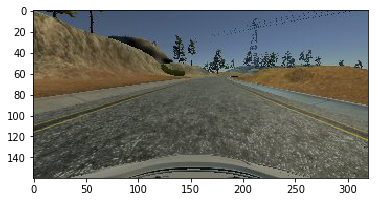

In [27]:
b0 = b[0]
b0_l = change_image_brightness_rgb(b0, s_low=0.2, s_high=0.75)
plt.imshow(b0_l)

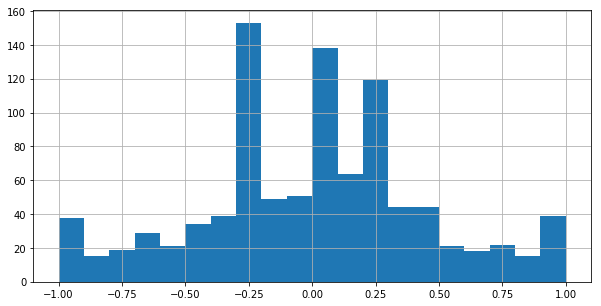

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.grid(True)
count, bins, _ = ax.hist(s, bins=20,histtype='bar' )

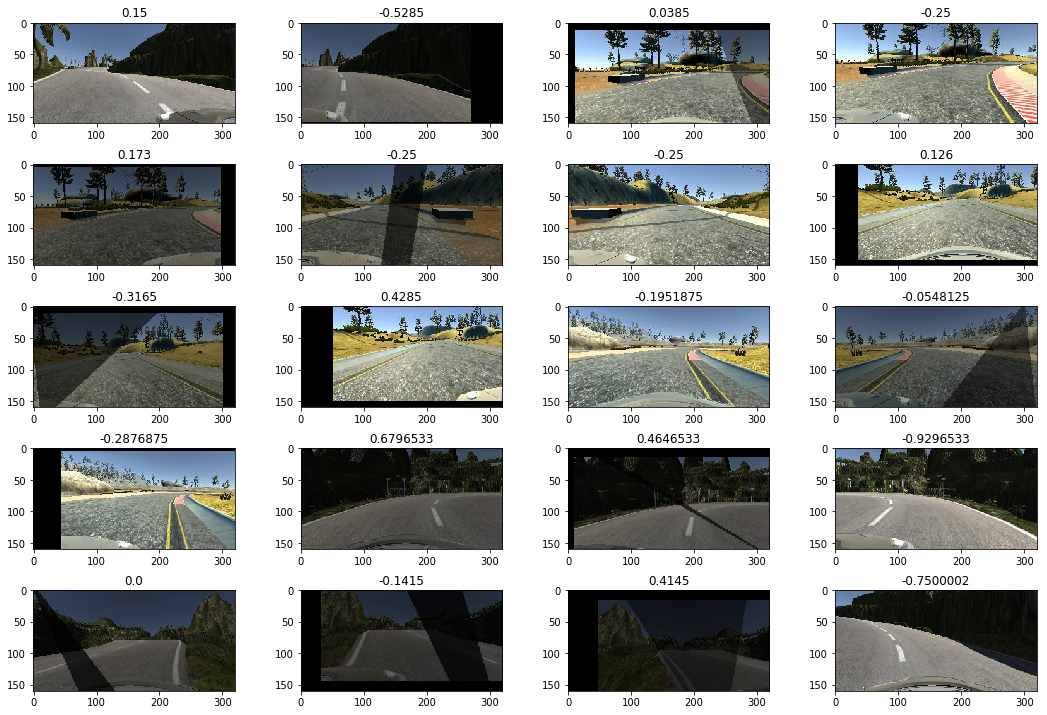

In [29]:
show_images(b[100:120], s[100:120], cols=4, fig_size=(15, 10))